# Resources used

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import openpyxl
from sklearn.tree import plot_tree

import seaborn as sns
import matplotlib.pyplot as plt

# Data collection and preprocessing

In [2]:
# Loading source data
data = pd.read_excel('Kazan.xlsx', engine='openpyxl')
data2 = pd.read_excel('Uljanovsk.xlsx', engine='openpyxl')

In [3]:
common_columns = list(set(data.columns) & set(data2.columns))

for column in common_columns:
    data[column] = data[column].astype(str)
    data2[column] = data2[column].astype(str)
    
merged_data_by_common_columns = pd.merge(data, data2, how='outer', on=common_columns)

In [4]:
selected_columns = [
    "Residual pipeline wall thickness, %",
    "Previous incidents on the pipeline section, K2",
    "Soil corrosion activity, К3",
    "Flooding (traces of flooding) of the channel, K4",
    "Intersections with communications, K5",
    "Practical Ki-values"
]

df_common = merged_data_by_common_columns[selected_columns].copy()

# rename the features
df_common = df_common.rename(columns={'Residual pipeline wall thickness, %': 'wall thickness K1, %', 
                                      'Previous incidents on the pipeline section, K2': 'incidents, K2', 
                                      'Soil corrosion activity, К3': 'soil corrosion, K3', 
                                      'Flooding (traces of flooding) of the channel, K4': 'flooding, K4',
                                      'Intersections with communications, K5': 'comm, K5',
                                      'Practical Ki-values': 'Ki'})
df_common

,"wall thickness K1, %","incidents, K2","soil corrosion, K3","flooding, K4","comm, K5",Ki
0,34.28571428571429,no,low,no,no,1.19833819463617
1,17.5,no,low,yes,no,1.03903553773497
2,20.0,yes,middle,yes,yes,1.11736007329225
3,52.5,no,low,no,no,1.2910500634762
4,17.5,yes,middle,yes,yes,1.24478341974083
...,...,...,...,...,...,...
106,64.28571428571428,yes,low,yes,no,0.983204860033999
107,44.44444444444444,yes,high,yes,yes,0.887564876999618
108,30.0,yes,low,no,no,1.42308010998884
109,50.0,yes,high,no,no,1.15897209358047


In [5]:
# Convert argument to a numeric type
df_common['wall thickness K1, %'] = pd.to_numeric(df_common['wall thickness K1, %'], errors='coerce')
df = df_common.dropna(subset=['wall thickness K1, %'], inplace=True)
df_common['Ki'] = pd.to_numeric(df_common['Ki'], errors='coerce')

# Return Series of codes as well as the index
df_common['incidents, K2'] = df_common['incidents, K2'].astype('category')
df_common['incidents, K2'] = df_common['incidents, K2'].cat.codes
df_common['soil corrosion, K3'] = df_common['soil corrosion, K3'].astype('category')
df_common['soil corrosion, K3'] = df_common['soil corrosion, K3'].cat.codes
df_common['flooding, K4'] = df_common['flooding, K4'].astype('category')
df_common['flooding, K4'] = df_common['flooding, K4'].cat.codes
df_common['comm, K5'] = df_common['comm, K5'].astype('category')
df_common['comm, K5'] = df_common['comm, K5'].cat.codes

In [6]:
for column in df_common.columns:
        df_common[column] = pd.to_numeric(df_common[column], errors='ignore')
        
for column in df_common.columns:
    if df_common[column].dtype in ['int64', 'float64'] and df_common[column].isnull().any():
        mean_value = df_common[column].mean()
        df_common.loc[:, column] = df_common[column].fillna(mean_value)
    elif df_common[column].dtype == 'object' and df_common[column].isnull().any():
        mode_value = df_common[column].mode()[0]
        df_common.loc[:, column] = df_common[column].fillna(mode_value)

for column in df_common.columns:
    if df_common[column].dtype == 'object':
        df_common.loc[:, column] = df_common[column].astype('category')
        
print(df_common.info())
df_common

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111 entries, 0 to 110
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   wall thickness K1, %  111 non-null    float64
 1   incidents, K2         111 non-null    int8   
 2   soil corrosion, K3    111 non-null    int8   
 3   flooding, K4          111 non-null    int8   
 4   comm, K5              111 non-null    int8   
 5   Ki                    111 non-null    float64
dtypes: float64(2), int8(4)
memory usage: 3.0 KB
None


,"wall thickness K1, %","incidents, K2","soil corrosion, K3","flooding, K4","comm, K5",Ki
0,34.285714,0,1,0,0,1.198338
1,17.500000,0,1,1,0,1.039036
2,20.000000,1,2,1,1,1.117360
3,52.500000,0,1,0,0,1.291050
4,17.500000,1,2,1,1,1.244783
...,...,...,...,...,...,...
106,64.285714,1,1,1,0,0.983205
107,44.444444,1,0,1,1,0.887565
108,30.000000,1,1,0,0,1.423080
109,50.000000,1,0,0,0,1.158972


# Exploratory data analysis

In [7]:
df_common_corr = df_common.copy()
df_common_corr = df_common_corr.rename(columns={'wall thickness K1, %' : 'K1', 
                                                'incidents, K2' : 'K2', 
                                                'soil corrosion, K3' : 'K3', 
                                                'flooding, K4' : 'K4',
                                                'comm, K5' : 'K5'})

In [8]:
corr_matrix = df_common_corr.corr()

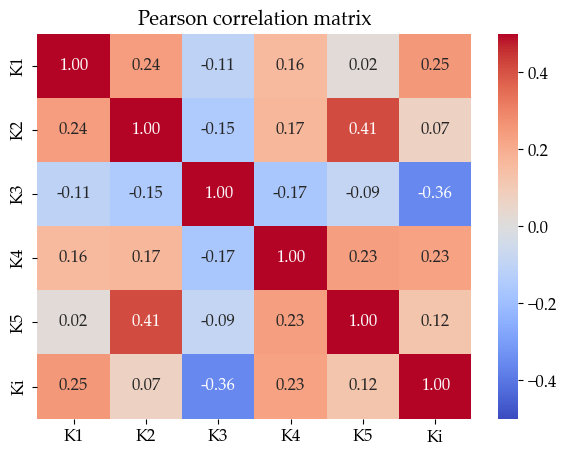

In [9]:
plt.figure(figsize=(7, 5))
plt.rcParams['font.family'] = 'Palatino Linotype'
plt.rcParams['font.size'] = 12
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, center=None, vmin=-0.5, vmax=0.5)
plt.savefig('pictures/corr_matrix.png', dpi = 300, transparent = True)
plt.title('Pearson correlation matrix')
plt.show()

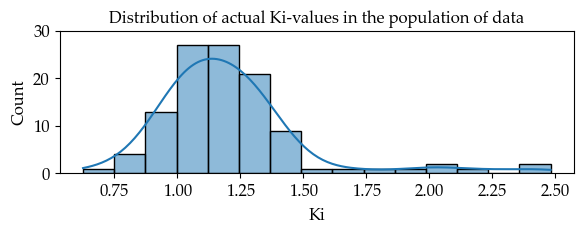

In [10]:
plt.figure(figsize=(6,2.5))
plt.rcParams['font.family'] = 'Palatino Linotype'
plt.rcParams['font.size'] = 12
plt.ylim(0, 30)
sns.histplot(data=df_common, x = 'Ki', bins = 15, kde = True)
plt.title('Distribution of actual Ki-values in the population of data', {'fontsize': 12})
plt.tight_layout()

plt.savefig('pictures/Ki_hist.png', dpi = 300, transparent = True)

In [11]:
def get_train_test_set(df, random_state=42):
    
    # data preprocessing
    scaler = MinMaxScaler()
    features_scaled = scaler.fit_transform(df)
    
    X = df.drop('Ki', axis=1)
    y = df['Ki']
        
    # division of the general population into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_set(df_common)

# Additional division of the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

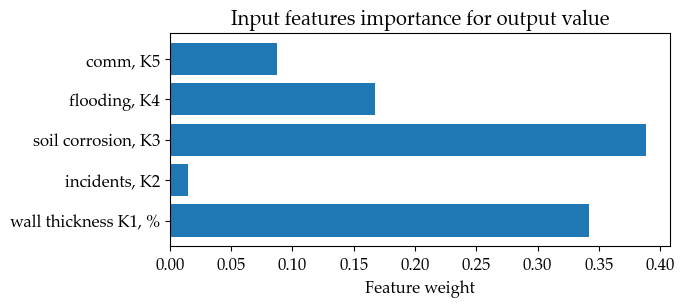

In [12]:
# Input features importance for output value
selector = GradientBoostingRegressor(random_state=42)
selector.fit(X_train, y_train)

feature_importances = selector.feature_importances_
features = X_train.columns

plt.figure(figsize=(7, 3))
plt.barh(range(len(features)), feature_importances, align='center')
plt.yticks(range(len(features)), features)
plt.xlabel('Feature weight')
plt.tight_layout()
plt.savefig('pictures/feature_important.png', dpi = 300, transparent = True)
plt.title('Input features importance for output value')
plt.show()

# Fit models

## Tensorflow

In [13]:
df_common = df_common.sort_values(by = 'Ki', ascending=True)
df_common.reset_index(drop= True, inplace=True)
df_common = df_common.iloc[8:85]
df_common.reset_index(drop= True, inplace=True)

# division of the general population into training and test sets
X_train, X_test, y_train, y_test = get_train_test_set(df_common, 1)

# Additional division of the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)  # 0.25 x 0.8 = 0.2

model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_dim=5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mape'])

history = model.fit(X_train, y_train, epochs=50, batch_size=11, validation_data=(X_val, y_val), verbose = 0)
#model.predict(X_train)

C:\Users\Nadezhda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
# loss (MSE & MAE) history
loss = history.history['loss']
val_loss = history.history['val_loss']
mae = history.history['mae']
val_mae = history.history['val_mae']
epochs = range(1, len(loss) + 1)

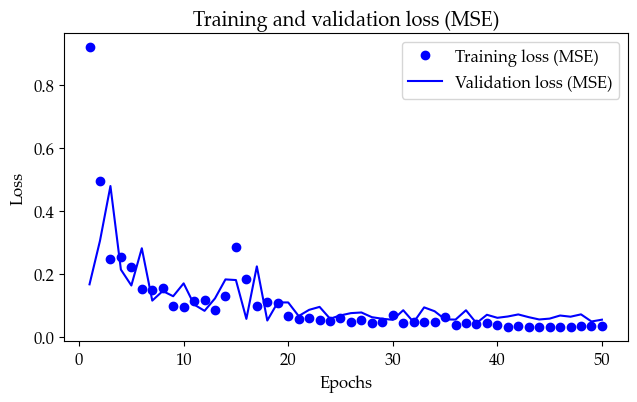

In [15]:
# MSE chart
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss (MSE)')
plt.plot(epochs, val_loss, 'b', label='Validation loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.rcParams['font.family'] = 'Palatino Linotype'
plt.rcParams['font.size'] = 12
plt.savefig('pictures/loss_MSE.png', dpi = 300, transparent = True)
plt.title('Training and validation loss (MSE)')
plt.show()

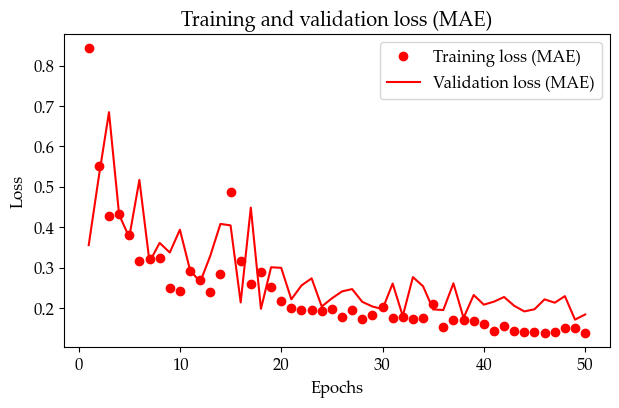

In [16]:
# MAE chart
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plt.plot(epochs, mae, 'ro', label='Training loss (MAE)')
plt.plot(epochs, val_mae, 'r', label='Validation loss (MAE)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.rcParams['font.family'] = 'Palatino Linotype'
plt.rcParams['font.size'] = 12
plt.savefig('pictures/loss_MAE.png', dpi = 300, transparent = True)
plt.title('Training and validation loss (MAE)')
plt.show()

In [17]:
# Evaluate model performance on test data
test_loss, test_mae, test_mape = model.evaluate(X_test, y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0397 - mae: 0.1551 - mape: 13.7058


In [18]:
predictions = {}
errors = pd.DataFrame()
MSE, MAE, MAPE = {}, {}, {}

In [19]:
# error in test set
y_pred = model.predict(X_test)
y_pred = np.asarray(list(i[0] for i in y_pred))
predictions['MLP'] = y_pred
errors['MLP'] = (y_pred - y_val)/y_val
MSE['MLP'], MAE['MLP'], MAPE['MLP'] = test_loss, test_mae, test_mape/100

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


## Support Vector Machine

In [20]:
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],  # Kernel coefficient
    'epsilon': [0.01, 0.1, 0.2, 0.5, 1],  # Margin parameter
    #'kernel': ['rbf', 'linear', 'poly', 'sigmoid']  # kernel type
    'kernel': ['rbf', 'linear', 'sigmoid']
}

svr = SVR()


grid_search = GridSearchCV(estimator=svr, 
                           param_grid=param_grid, 
                           cv=5, 
                           scoring='neg_mean_squared_error', 
                           verbose=2, n_jobs=-1)

In [21]:
%%time

# fit model
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
CPU times: total: 812 ms
Wall time: 22.7 s


GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100],
                         'epsilon': [0.01, 0.1, 0.2, 0.5, 1],
                         'gamma': ['scale', 'auto', 0.01, 0.1, 1],
                         'kernel': ['rbf', 'linear', 'sigmoid']},
             scoring='neg_mean_squared_error', verbose=2)

In [22]:
print("Best SVM-params:", grid_search.best_params_)

Best SVM-params: {'C': 100, 'epsilon': 0.01, 'gamma': 1, 'kernel': 'rbf'}


In [23]:
best_svr = grid_search.best_estimator_
y_pred = best_svr.predict(X_test)
predictions['SVM'] = y_pred
errors['SVM'] = (y_pred - y_val)/y_val

In [24]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}")

Mean Squared Error: 0.00862931062469314
Mean Absolute Error: 0.07680586252391533
Mean Absolute Percentage Error: 0.06878252667686846


In [25]:
MSE['SVM'], MAE['SVM'], MAPE['SVM'] = mse, mae, mape

## Ensemble Methods

### Gradient Boosting

In [26]:
# Pipeline for Gradient Boosting
gb_pipeline = Pipeline([
    ('regressor', GradientBoostingRegressor())
])

# Parameters GridSearchCV for Gradient Boosting
gb_params = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__learning_rate': [0.01, 0.1, 0.2],
    'regressor__max_depth': [3, 5, 7]
}

# Creation and execution GridSearchCV for Gradient Boosting
gb_grid = GridSearchCV(gb_pipeline, gb_params, cv=5, scoring='neg_mean_absolute_percentage_error')
gb_grid.fit(X_train, y_train)

print("Best GBRT-params:", gb_grid.best_params_)

Best GBRT-params: {'regressor__learning_rate': 0.01, 'regressor__max_depth': 5, 'regressor__n_estimators': 100}


In [27]:
best_gb = gb_grid.best_estimator_
y_pred = best_gb.predict(X_test)
predictions['GBRT'] = y_pred
errors['GBRT'] = (y_pred - y_val)/y_val

In [28]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}")

Mean Squared Error: 0.007831152749126095
Mean Absolute Error: 0.07152574502785825
Mean Absolute Percentage Error: 0.06386968135117513


In [29]:
MSE['GBRT'], MAE['GBRT'], MAPE['GBRT'] = mse, mae, mape

### Random Forest

In [30]:
# Pipeline for Random Forest
rf_pipeline = Pipeline([
    ('regressor', RandomForestRegressor())
])

# Parameters GridSearchCV for Random Forest
rf_params = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_features': [0.3, 'sqrt', 'log2'],
    'regressor__max_depth': [5, 10, 15]
}

# Creation and execution GridSearchCV for Random Forest
rf_grid = GridSearchCV(rf_pipeline, rf_params, cv=5, scoring='neg_mean_absolute_percentage_error')
rf_grid.fit(X_train, y_train)

print("Best RF-params:", rf_grid.best_params_)

Best RF-params: {'regressor__max_depth': 5, 'regressor__max_features': 'sqrt', 'regressor__n_estimators': 300}


In [31]:
best_rf = rf_grid.best_estimator_
best_r_rf = rf_grid.best_estimator_.named_steps['regressor']
y_pred = best_rf.predict(X_test)
predictions['RF'] = y_pred
errors['RF'] = (y_pred - y_val)/y_val

In [32]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}")

Mean Squared Error: 0.009476080427432901
Mean Absolute Error: 0.080215067844874
Mean Absolute Percentage Error: 0.07142929465115616


In [33]:
MSE['RF'], MAE['RF'], MAPE['RF'] = mse, mae, mape

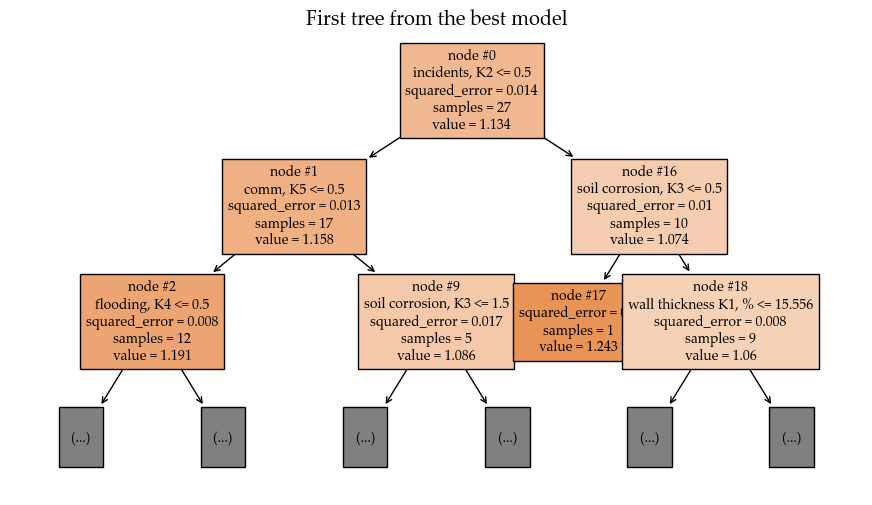

In [34]:
# Drawing the first tree from the best model
fig, ax = plt.subplots(figsize=(11, 6))
plot_tree(best_r_rf.estimators_[0], 
          filled=True, 
          feature_names=X_train.columns.tolist(), 
          ax=ax, 
          fontsize=10, 
          max_depth=2, 
          node_ids=True)

plt.rcParams['font.family'] = 'Palatino Linotype'
plt.rcParams['font.size'] = 12
#plt.savefig('pictures/tree.png', dpi = 300, transparent = True)
plt.title('First tree from the best model')

plt.show()

# Сomparison of model error indicators

Error indicator with a full set input features


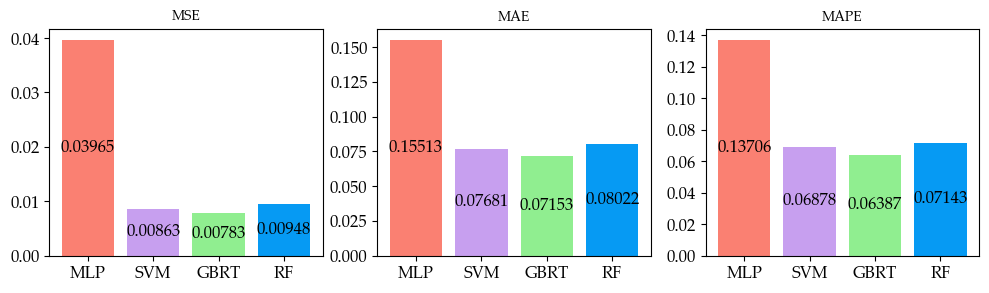

In [35]:
models = list(MSE)
plt.figure(figsize=(12, 10))

for index, score in enumerate(['MSE', 'MAE', 'MAPE']):
    scores = [MSE, MAE, MAPE]
    
    plt.subplot(3, 3, index + 1)
    bars =plt.bar(models, 
            scores[index].values(), 
            color=['#FA8072', '#C79FEF', '#90EE90', '#069AF3'],
            align='center')
    
    plt.bar_label(bars, label_type='center', fmt='%.5f')
    plt.title(score, fontsize = 10)
    
plt.tight_layout
plt.rcParams['font.family'] = 'Palatino Linotype'
plt.rcParams['font.size'] = 10
plt.savefig('pictures/scores.png', dpi = 300, transparent = True)
print('Error indicator with a full set input features')

plt.show()

In [36]:
errors.reset_index(drop=True, inplace=True)
errors.reset_index(drop=False, inplace=True)
errors.head()

,index,MLP,SVM,GBRT,RF
0,0,0.000318,-0.113349,-0.104617,-0.069109
1,1,0.298689,0.073657,0.073111,0.064914
2,2,-0.162757,-0.035765,-0.062241,-0.050880
3,3,0.140352,0.069279,0.085660,0.104738
4,4,0.089043,0.080268,0.130279,0.023215


In [37]:
df_errors1 = errors[['index', 'MLP']]
df_errors1.insert(loc=2,column='score', value='MLP')
df_errors1 = df_errors1.rename(columns={'MLP':'error'})

df_errors2 = errors[['index', 'SVM']]
df_errors2.insert(loc=2,column='score', value='SVM')
df_errors2 = df_errors2.rename(columns={'SVM':'error'})

df_errors3 = errors[['index', 'GBRT']]
df_errors3.insert(loc=2,column='score', value='GBRT')
df_errors3 = df_errors3.rename(columns={'GBRT':'error'})

df_errors4 = errors[['index', 'RF']]
df_errors4.insert(loc=2,column='score', value='RF')
df_errors4 = df_errors4.rename(columns={'RF':'error'})

df_errors = pd.concat([df_errors1, df_errors2, df_errors3, df_errors4], axis=0)
df_errors = df_errors.rename(columns={'index':'Incident number', 
                                      'error':'Relative error',
                                      'score': 'Model'})
df_errors.head(4)

,Incident number,Relative error,Model
0,0,0.000318,MLP
1,1,0.298689,MLP
2,2,-0.162757,MLP
3,3,0.140352,MLP


<Figure size 500x1200 with 0 Axes>

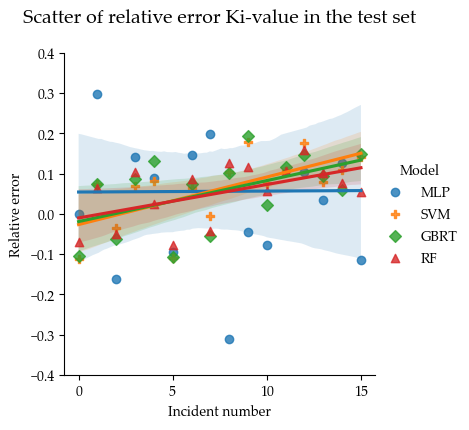

In [38]:
# Relative error on validation data
plt.figure(figsize=(5, 12))

sns.lmplot(x='Incident number', 
           y='Relative error', 
           data=df_errors,
           fit_reg=True, 
           hue='Model', 
           legend=True,
           markers=["o", "P", "D", "^"],
           scatter=True, 
           height=4)

#plt.legend(loc='best')
plt.ylim(-0.4, 0.4)
plt.rcParams['font.size'] = 14
plt.savefig('pictures/relative_error.png', dpi = 300, transparent = True)
plt.title('Scatter of relative error Ki-value in the test set\n', {'fontsize': 14})

plt.show()

MLP showed the greatest spread of relative error, due to which the model was excluded from further analysis

# Feature filtering and model re-estimation

We remove the weakest feature – `incidents, K2` (justification – Sub 3: Exploratory data analysis). We exclude the weakest method – MLP.

In [39]:
#X_train, X_test, y_train, y_test = get_train_test_set(df_common, 1)
X_train2 = X_train.drop(['incidents, K2'], axis=1)
X_test2 = X_test.drop(['incidents, K2'], axis=1)

In [40]:
MSE2, MAE2, MAPE2 = {}, {}, {}

## Support Vector Machine

In [41]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],
    'epsilon': [0.01, 0.1, 0.2, 0.5, 1],
    #'kernel': ['rbf', 'linear', 'poly', 'sigmoid']
    'kernel': ['rbf', 'linear', 'sigmoid']
}

svr = SVR()

grid_search = GridSearchCV(estimator=svr, 
                           param_grid=param_grid, 
                           cv=5, 
                           scoring='neg_mean_squared_error', 
                           verbose=2, n_jobs=-1)

In [42]:
%%time

grid_search.fit(X_train2, y_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
CPU times: total: 750 ms
Wall time: 23.4 s


GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100],
                         'epsilon': [0.01, 0.1, 0.2, 0.5, 1],
                         'gamma': ['scale', 'auto', 0.01, 0.1, 1],
                         'kernel': ['rbf', 'linear', 'sigmoid']},
             scoring='neg_mean_squared_error', verbose=2)

In [43]:
print("Best SVM-params:", grid_search.best_params_)

Best SVM-params: {'C': 100, 'epsilon': 0.01, 'gamma': 1, 'kernel': 'rbf'}


In [44]:
best_svr = grid_search.best_estimator_
y_pred = best_svr.predict(X_test2)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}")

Mean Squared Error: 0.008597600115871459
Mean Absolute Error: 0.07712471761182538
Mean Absolute Percentage Error: 0.06885714754208387


In [45]:
MSE2['SVM'], MAE2['SVM'], MAPE2['SVM'] = mse, mae, mape

## Gradient Boosting

In [46]:
gb_pipeline = Pipeline([
    ('regressor', GradientBoostingRegressor())
])

gb_params = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__learning_rate': [0.01, 0.1, 0.2],
    'regressor__max_depth': [3, 5, 7]
}

gb_grid = GridSearchCV(gb_pipeline, gb_params, cv=5, scoring='neg_mean_absolute_percentage_error')
gb_grid.fit(X_train2, y_train)

print("Best GBRT-params:", gb_grid.best_params_)

Best GBRT-params: {'regressor__learning_rate': 0.01, 'regressor__max_depth': 3, 'regressor__n_estimators': 100}


In [47]:
best_gb = gb_grid.best_estimator_
y_pred = best_gb.predict(X_test2)

In [48]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}")

Mean Squared Error: 0.00718586338093125
Mean Absolute Error: 0.06819794028468046
Mean Absolute Percentage Error: 0.06068815444226172


In [49]:
MSE2['GBRT'], MAE2['GBRT'], MAPE2['GBRT'] = mse, mae, mape

## Random Forest

In [50]:
rf_pipeline = Pipeline([
    ('regressor', RandomForestRegressor())
])

rf_params = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_features': [0.3, 'sqrt', 'log2'],
    'regressor__max_depth': [5, 10, 15]
}

rf_grid = GridSearchCV(rf_pipeline, rf_params, cv=5, scoring='neg_mean_absolute_percentage_error')
rf_grid.fit(X_train2, y_train)

print("Best RF-params:", rf_grid.best_params_)

Best RF-params: {'regressor__max_depth': 5, 'regressor__max_features': 'log2', 'regressor__n_estimators': 100}


In [51]:
best_rf = rf_grid.best_estimator_
best_r_rf = rf_grid.best_estimator_.named_steps['regressor']
y_pred = best_rf.predict(X_test2)

In [52]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}")

Mean Squared Error: 0.007643669136165522
Mean Absolute Error: 0.07047305265263731
Mean Absolute Percentage Error: 0.06294790372088985


In [53]:
MSE2['RF'], MAE2['RF'], MAPE2['RF'] = mse, mae, mape

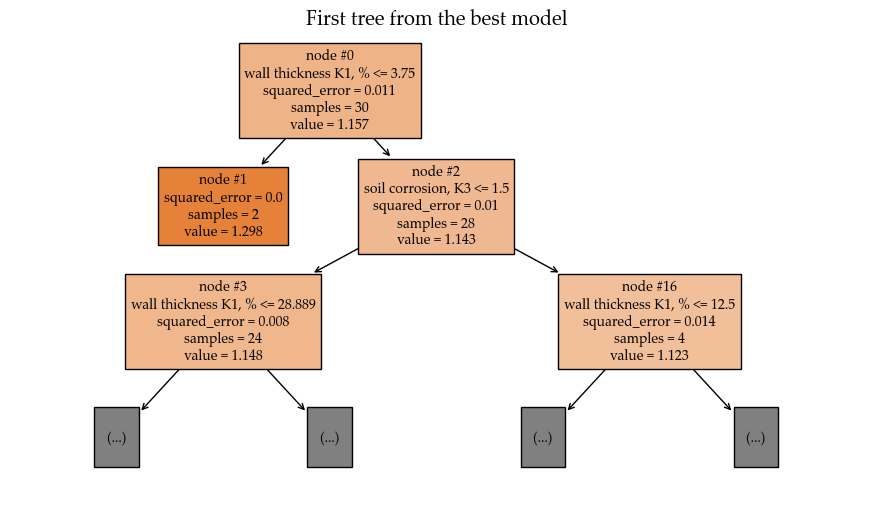

In [54]:
# Drawing the first tree from the best model
fig, ax = plt.subplots(figsize=(11, 6))
plot_tree(best_r_rf.estimators_[0], 
          filled=True, 
          feature_names=X_train2.columns.tolist(), 
          ax=ax, 
          fontsize=10, 
          max_depth=2, 
          node_ids=True)

plt.rcParams['font.family'] = 'Palatino Linotype'
plt.rcParams['font.size'] = 12
plt.savefig('pictures/tree.png', dpi = 300, transparent = True)
plt.title('First tree from the best model')

plt.show()

## Сomparison of model error indicators

Error indicator without the K2-features


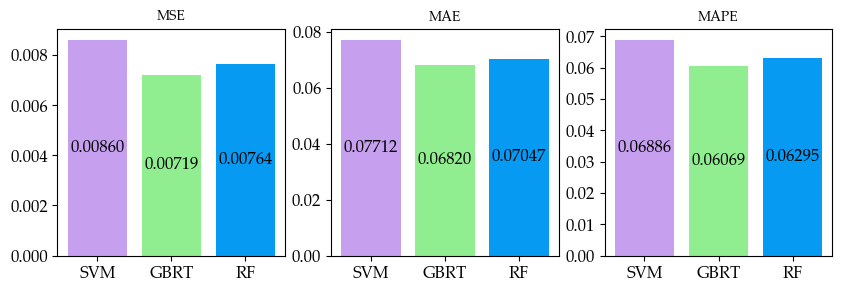

In [55]:
models = list(MSE2)
plt.figure(figsize=(10, 10))

for index, score in enumerate(['MSE', 'MAE', 'MAPE']):
    scores = [MSE2, MAE2, MAPE2]
    
    plt.subplot(3, 3, index + 1)
    bars =plt.bar(models, 
            scores[index].values(), 
            color=['#C79FEF', '#90EE90', '#069AF3'],
            align='center')
    
    plt.bar_label(bars, label_type='center', fmt='%.5f')
    plt.title(score, fontsize = 10)
    
plt.tight_layout
plt.rcParams['font.family'] = 'Palatino Linotype'
plt.rcParams['font.size'] = 10
plt.savefig('pictures/scores2.png', dpi = 300, transparent = True)
print('Error indicator without the K2-features')
plt.show()

**Conclusion**: The best result was obtained for the GBRT-model